## Import libraries, dataset and read it

In [4]:
import pandas as pd
import numpy as np

In [5]:
from datasets import load_dataset

dataset = load_dataset("bwbayu/job_cv_supervised")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'clean_cv', 'clean_jd', 'label'],
        num_rows: 31203
    })
})

In [7]:
df = dataset['train'].to_pandas().reset_index(drop=True)

In [8]:
df

,Unnamed: 0,clean_cv,clean_jd,label
0,0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1
1,1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1
2,2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1
3,3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1
4,4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1
...,...,...,...,...
31198,31198,watch officer watch officer watch officer gnos...,halo learn grow skill award winning startup te...,0
31199,31199,watch officer watch officer watch officer gnos...,qualification maximum age twenty eight year ol...,0
31200,31200,watch officer watch officer watch officer gnos...,responsibility learn real case situation under...,0
31201,31201,watch officer watch officer watch officer gnos...,job purpose ensure application development pri...,0


In [9]:
del df['Unnamed: 0']

In [10]:
df.head()

,clean_cv,clean_jd,label
0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1
1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1
2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1
3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1
4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1


In [11]:
df = df.rename(columns={'clean_cv': 'resume_text'})
df = df.rename(columns={'clean_jd': 'job_description_text'})

## EDA and feature engineering

In [12]:
df.isnull().sum()

resume_text             0
job_description_text    0
label                   0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31203 entries, 0 to 31202
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   resume_text           31203 non-null  object
 1   job_description_text  31203 non-null  object
 2   label                 31203 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 731.4+ KB


In [14]:
#1 = CV matches / candidate fits job, 0 = does not match
df['label'].value_counts(normalize=True)

label
1    0.503734
0    0.496266
Name: proportion, dtype: float64

In [15]:
df_text = pd.DataFrame()

df_text['resume_len'] = df['resume_text'].apply(len)
df_text['job_len'] = df['job_description_text'].apply(len)

print(df_text[['resume_len', 'job_len']].describe())

         resume_len       job_len
count  31203.000000  31203.000000
mean    3892.873794   1609.138929
std     3108.458738   1310.820590
min      112.000000    142.000000
25%     1638.000000    655.000000
50%     3502.000000   1122.000000
75%     5039.000000   2127.000000
max    21044.000000   6080.000000


In [16]:
df.head()

,resume_text,job_description_text,label
0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1
1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1
2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1
3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1
4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1


In [17]:
df['resume_text'].nunique()

637

In [18]:
df['job_description_text'].nunique()

452

In [19]:
df['combined_text'] = df['resume_text'] + " [SEP] " + df['job_description_text']
df['combined_text'].nunique()

31203

In [20]:
df.head()

,resume_text,job_description_text,label,combined_text
0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1,result oriented organized bilingual accounting...
1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1,result oriented organized bilingual accounting...
2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1,result oriented organized bilingual accounting...
3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1,result oriented organized bilingual accounting...
4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1,result oriented organized bilingual accounting...


## Split the data

Since the same CV appears in multiple CV–JD pairs, we use a group-based split by CV so that the same cv doesn't repeat in cv-jd pairs across mutliple splits to prevent data leakage and ensure realistic evaluation.

In [21]:
# from sklearn.model_selection import train_test_split

# df_train, df_temp = train_test_split(df, test_size=0.3, random_state=1, stratify=df['label'])
# df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=1, stratify=df_temp['label'])


# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

# y_train = df_train.label.values
# y_val = df_val.label.values
# y_test = df_test.label.values

# del df_train['label']
# del df_val['label']
# del df_test['label']

In [22]:
from sklearn.model_selection import train_test_split

#Get unique CVs
unique_cvs = df['resume_text'].unique()

# Split CVs
train_cvs, temp_cvs = train_test_split(
    unique_cvs, test_size=0.3, random_state=1
)

val_cvs, test_cvs = train_test_split(
    temp_cvs, test_size=0.5, random_state=1
)

# Create splits
df_train = df[df['resume_text'].isin(train_cvs)]
df_val   = df[df['resume_text'].isin(val_cvs)]
df_test  = df[df['resume_text'].isin(test_cvs)]

# Reset index
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

y_train = df_train.label.values
y_val = df_val.label.values
y_test = df_test.label.values

del df_train['label']
del df_val['label']
del df_test['label']

### Converting Resume Text and Job Description Text into Vectors and Computing Cosine Similarity as a New Feature

#### TF-IDF Vectorizer
- Converts text into numbers that reflect how important each word is in a document relative to the whole collection of documents.
- **Output:** A numeric vector for each document, where each element represents the TF-IDF score of a word from the vocabulary.

#### Cosine Similarity
- Computes the angle between the two TF-IDF vectors.
- `1` → texts are very similar
- `0` → texts are completely different

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# TF-IDF Vectorizer
# Create SHARED vocabulary for cosine similarity
shared_tfidf = TfidfVectorizer(max_features=5000)

# Fit on BOTH resumes and JDs
all_train_text = pd.concat([
    df_train['resume_text'], 
    df_train['job_description_text']
])
shared_tfidf.fit(all_train_text)


X_train_resume = shared_tfidf.transform(df_train['resume_text'])
X_train_jd     = shared_tfidf.transform(df_train['job_description_text'])

X_val_resume = shared_tfidf.transform(df_val['resume_text'])
X_val_jd     = shared_tfidf.transform(df_val['job_description_text'])

X_test_resume = shared_tfidf.transform(df_test['resume_text'])
X_test_jd     = shared_tfidf.transform(df_test['job_description_text'])


# Function to compute cosine similarity row-wise
def rowwise_cosine(X1, X2):
    X1_norm = normalize(X1)
    X2_norm = normalize(X2)
    return np.array(X1_norm.multiply(X2_norm).sum(axis=1)).ravel()

# Compute cosine similarity efficiently
cos_sim_train = rowwise_cosine(X_train_resume, X_train_jd)
cos_sim_val   = rowwise_cosine(X_val_resume, X_val_jd)
cos_sim_test  = rowwise_cosine(X_test_resume, X_test_jd)

In [24]:
from scipy.sparse import hstack

tfidf = TfidfVectorizer(max_features=5000)

X_train_combined = tfidf.fit_transform(df_train['combined_text'])
X_val_combined   = tfidf.transform(df_val['combined_text'])
X_test_combined  = tfidf.transform(df_test['combined_text'])

X_train_final = hstack([X_train_combined, cos_sim_train.reshape(-1, 1)])
X_val_final = hstack([X_val_combined, cos_sim_val.reshape(-1, 1)])
X_test_final = hstack([X_test_combined, cos_sim_test.reshape(-1, 1)])

### check features ranges

In [25]:
# Check TF-IDF range
print("TF-IDF Combined features range:")
print(f"  Min: {X_train_combined.min():.6f}")
print(f"  Max: {X_train_combined.max():.6f}")
print(f"  Mean: {X_train_combined.mean():.6f}")

# Check cosine similarity range  
print("\nCosine similarity range:")
print(f"  Min: {cos_sim_train.min():.3f}")
print(f"  Max: {cos_sim_train.max():.3f}")
print(f"  Mean: {cos_sim_train.mean():.3f}")

TF-IDF Combined features range:
  Min: 0.000000
  Max: 0.842677
  Mean: 0.002666

Cosine similarity range:
  Min: 0.000
  Max: 0.601
  Mean: 0.083


In [ ]:
#feature_names = list(tfidf.get_feature_names_out()) + ['cosine_similarity']
#feature_names

### Training the model with logistic regression

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [82]:
for C in [0.001, 0.01, 0.1, 1, 10]: 
    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train_final, y_train)
    
    y_val_proba = model.predict_proba(X_val_final)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    
    print('%4s -> %.3f' % (C, auc))

0.001 -> 0.768
0.01 -> 0.829
 0.1 -> 0.894
   1 -> 0.911
  10 -> 0.909


In [83]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_final, y_train)

# Get predictions
y_val_proba = model.predict_proba(X_val_final)[:, 1]
y_pred = model.predict(X_val_final)

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2%}")

Accuracy: 72.86%


In [84]:
auc_val = roc_auc_score(y_val, y_val_proba)
print("Validation AUC:", auc_val)

Validation AUC: 0.9106833672611366


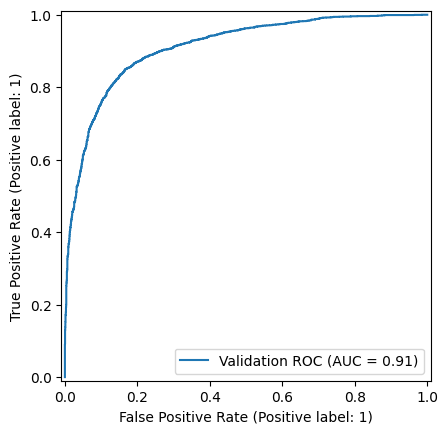

In [85]:
RocCurveDisplay.from_predictions(y_val, y_val_proba, name="Validation ROC")
plt.show()

In [86]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.49      0.64      2381
           1       0.66      0.96      0.78      2391

    accuracy                           0.73      4772
   macro avg       0.79      0.73      0.71      4772
weighted avg       0.79      0.73      0.71      4772



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Class names (adjust if your labels are different)
class_names = [0, 1]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix")
plt.show()


In [87]:
#test dataset
y_test_proba = model.predict_proba(X_test_final)[:, 1]
y_pred = model.predict(X_test_final)
auc = roc_auc_score(y_test, y_test_proba)
print(auc)

0.8519806529769471


In [90]:
r = classification_report(y_test, y_pred)
print(r)

              precision    recall  f1-score   support

           0       0.91      0.41      0.56      2598
           1       0.59      0.96      0.73      2322

    accuracy                           0.67      4920
   macro avg       0.75      0.68      0.65      4920
weighted avg       0.76      0.67      0.64      4920



### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_final, y_train)

y_val_proba = dt.predict_proba(X_val_final)[:, 1]
y_pred = dt.predict(X_val_final)

auc_val = roc_auc_score(y_val, y_val_proba)
print("Validation AUC:", auc_val)

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

print("Depth -> Auc")
print("-" * 50)

for depth in depths: 
    dt = DecisionTreeClassifier(
        max_depth=depth,
        class_weight='balanced',
        random_state=42
    )
    dt.fit(X_train_final, y_train)
    
    y_val_proba = dt.predict_proba(X_val_final)[:, 1]
    
    auc = roc_auc_score(y_val, y_val_proba)
    
    print(f'{str(depth):>4} -> {auc:>11.3f}')

In [ ]:
#max_depth = 3

In [ ]:
depths = [2, 3, 4, 5, 6]

print("Depth | Min Leaf | AUC")
print("-" * 50)

for depth in depths:
    for min_leaf in [1, 5, 10, 15, 20, 100, 200]:
        dt = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=min_leaf,
            class_weight='balanced',
            random_state=42
        )
        dt.fit(X_train_final, y_train)
        
        y_val_proba = dt.predict_proba(X_val_final)[:, 1]
    
        auc = roc_auc_score(y_val, y_val_proba)
        
        print(f'{str(depth):>4} | {min_leaf:>9} | {auc:>11.3f}')

In [ ]:
#Depth = 4, min_samples_leaf = 100

In [ ]:
dt = DecisionTreeClassifier(
            max_depth=4,
            min_samples_leaf=100,
            class_weight='balanced',
            random_state=42
        )
dt.fit(X_train_final, y_train)
        
y_val_proba = dt.predict_proba(X_val_final)[:, 1]
y_pred = dt.predict(X_val_final)
    
auc_val = roc_auc_score(y_val, y_val_proba)
print("Validation AUC:", auc_val)

In [ ]:
report = classification_report(y_val, y_pred)
print(report)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("n_estimators -> AUC")
print("-" * 50)

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_train_final, y_train)
    
    y_pred = rf.predict(X_val_final)
    y_val_proba = rf.predict_proba(X_val_final)[:, 1]
    
    auc = roc_auc_score(y_val, y_val_proba)
        
    print(f'{str(n):>4} | {auc:>9}')

In [ ]:
# scores = []

# for d in [5, 10, 15]:
#     for n in range(10, 201, 10):
#         rf = RandomForestClassifier(n_estimators=n,
#                                     max_depth=d,
#                                     class_weight='balanced',
#                                     random_state=42,
#                                     n_jobs=-1)
#         rf.fit(X_train_final, y_train)

#         y_val_proba = rf.predict_proba(X_val_final)[:, 1]
#         auc = roc_auc_score(y_val, y_val_proba)

#         scores.append((d, n, auc))

In [ ]:
# columns = ['max_depth', 'n_estimators', 'auc']
# df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
# for d in [5, 10, 15]:
#     df_subset = df_scores[df_scores.max_depth == d]
    
#     plt.plot(df_subset.n_estimators, df_subset.auc,
#              label='max_depth=%d' % d)

# plt.legend()

In [ ]:
print("n_estimators | max_depth -> AUC")
print("-" * 50)

for n in range(10, 101, 10):
    for d in [10 ,15, 30, 40, 50]:
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    class_weight='balanced',
                                    random_state=42,
                                    n_jobs=-1)
        rf.fit(X_train_final, y_train)
        
        y_pred = rf.predict(X_val_final)
        y_val_proba = rf.predict_proba(X_val_final)[:, 1]
        
        auc = roc_auc_score(y_val, y_val_proba)
            
        print(f'{str(n):>4} | {str(d):>4}  | {auc:>9}')

In [ ]:
n = 50
d = 30

In [ ]:
rf = RandomForestClassifier(n_estimators=n,
                            max_depth=d,
                            class_weight='balanced',
                            random_state=42,
                            n_jobs=-1)
rf.fit(X_train_final, y_train)

y_pred = rf.predict(X_val_final)
y_val_proba = rf.predict_proba(X_val_final)[:, 1]
    
auc = roc_auc_score(y_val, y_val_proba)
auc

In [ ]:
report = classification_report(y_val, y_pred)
print(report)

### XGBoost

In [23]:
!pip install xgboost

In [26]:
import xgboost as xgb

tfidf_features = list(tfidf.get_feature_names_out())
features = tfidf_features + ["cosine_similarity"]

dtrain = xgb.DMatrix(X_train_final, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_final, label=y_val, feature_names=features)

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=20)

In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

In [28]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [50]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=81,
                  verbose_eval=5,
                  evals=watchlist)

In [51]:
s = output.stdout
print(s)

[0]	train-auc:0.88399	val-auc:0.67345
[5]	train-auc:0.96756	val-auc:0.80853
[10]	train-auc:0.98148	val-auc:0.84430
[15]	train-auc:0.98570	val-auc:0.85686
[20]	train-auc:0.99027	val-auc:0.87394
[25]	train-auc:0.99257	val-auc:0.87829
[30]	train-auc:0.99464	val-auc:0.88155
[35]	train-auc:0.99577	val-auc:0.88847
[40]	train-auc:0.99701	val-auc:0.89405
[45]	train-auc:0.99800	val-auc:0.89425
[50]	train-auc:0.99843	val-auc:0.89989
[55]	train-auc:0.99882	val-auc:0.89999
[60]	train-auc:0.99912	val-auc:0.90228
[65]	train-auc:0.99926	val-auc:0.90588
[70]	train-auc:0.99955	val-auc:0.90715
[75]	train-auc:0.99972	val-auc:0.90980
[80]	train-auc:0.99982	val-auc:0.91160
[85]	train-auc:0.99990	val-auc:0.90984
[90]	train-auc:0.99993	val-auc:0.91088
[95]	train-auc:0.99995	val-auc:0.91207
[99]	train-auc:0.99996	val-auc:0.91233



In [53]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [54]:
df_score = parse_xgb_output(output)

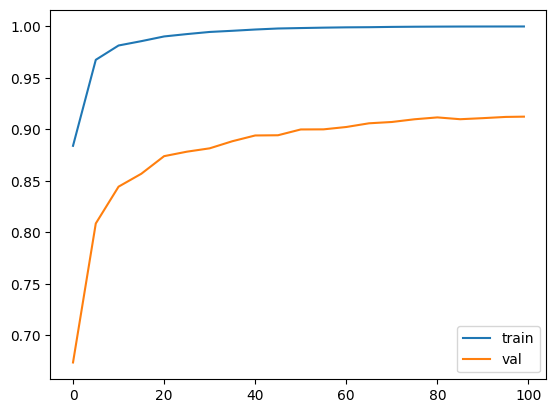

In [55]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [59]:
for eta in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f"\nTesting eta = {eta}")

    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
    }

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=151,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    print(f"Best iteration: {model.best_iteration}")
    print(f"Best val AUC: {model.best_score}")



Testing eta = 0.1
Best iteration: 62
Best val AUC: 0.9068898295810747

Testing eta = 0.2
Best iteration: 109
Best val AUC: 0.9303992590160743

Testing eta = 0.3
Best iteration: 79
Best val AUC: 0.9139631134604409

Testing eta = 0.4
Best iteration: 35
Best val AUC: 0.880440634600106

Testing eta = 0.5
Best iteration: 49
Best val AUC: 0.9036106981749951


In [60]:
%%capture output

xgb_params = {
    'eta': 0.2, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=110,
                  verbose_eval=10,
                  evals=watchlist)

In [61]:
s = output.stdout
print(s)

[0]	train-auc:0.88399	val-auc:0.67345
[10]	train-auc:0.97524	val-auc:0.84120
[20]	train-auc:0.98512	val-auc:0.86239
[30]	train-auc:0.99163	val-auc:0.88503
[40]	train-auc:0.99465	val-auc:0.89637
[50]	train-auc:0.99615	val-auc:0.90807
[60]	train-auc:0.99763	val-auc:0.91696
[70]	train-auc:0.99842	val-auc:0.91950
[80]	train-auc:0.99908	val-auc:0.92323
[90]	train-auc:0.99939	val-auc:0.92751
[100]	train-auc:0.99958	val-auc:0.93008
[109]	train-auc:0.99977	val-auc:0.93040



In [33]:
for min_child_weight in [2, 5, 8]:
    print(f"\n min_child_weight = {min_child_weight}")

    xgb_params = {
        'eta': 0.2,
        'max_depth': 6,
        'min_child_weight': min_child_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
    }

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=101,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    print(f"Best iteration: {model.best_iteration}")
    print(f"Best val AUC: {model.best_score}")



 min_child_weight = 2
Best iteration: 66
Best val AUC: 0.9345491132837318

 min_child_weight = 5
Best iteration: 70
Best val AUC: 0.9265222851126416

 min_child_weight = 8
Best iteration: 68
Best val AUC: 0.9352345199018228


In [35]:
eta=0.2
rounds=67 
max_depth=6
min_child_weight=2

In [75]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
        'eta': 0.2,
        'max_depth': 6,
        'min_child_weight': 2,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
    }

model = xgb.train(xgb_params, dtrain, evals=watchlist, early_stopping_rounds=5, verbose_eval=False, num_boost_round=67)

In [76]:
y_val_proba = model.predict(dval)
y_pred  = (y_val_proba >= 0.5).astype(int)
roc_auc_score(y_val, y_val_proba)

0.92530692673474

In [77]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.56      0.70      2381
           1       0.69      0.96      0.80      2391

    accuracy                           0.76      4772
   macro avg       0.81      0.76      0.75      4772
weighted avg       0.81      0.76      0.75      4772



#### test dataset

In [78]:
dtest = xgb.DMatrix(X_test_final, label=y_test, feature_names=features)
y_test_proba = model.predict(dtest)
y_pred_test  = (y_test_proba >= 0.5).astype(int)
roc_auc_score(y_test, y_test_proba)

0.8741904758115797

In [80]:
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.51      0.66      2598
           1       0.64      0.96      0.76      2322

    accuracy                           0.72      4920
   macro avg       0.78      0.73      0.71      4920
weighted avg       0.79      0.72      0.71      4920



## using the model

In [68]:
import scipy.sparse as sp

# Combine train + val
X_trainval_final = sp.vstack([X_train_final, X_val_final])
y_trainval = np.concatenate([y_train, y_val])

# Create DMatrix for XGBoost
dtrainval = xgb.DMatrix(X_trainval_final, label=y_trainval, feature_names=features)
dtest = xgb.DMatrix(X_test_final, label=y_test, feature_names=features)

In [107]:
xgb_params = {
        'eta': 0.15,
        'max_depth': 6,
        'min_child_weight': 2,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
    }

model = xgb.train(xgb_params, dtrainval, evals=watchlist, early_stopping_rounds=5, verbose_eval=False, num_boost_round=300)

In [108]:
dtest = xgb.DMatrix(X_test_final, label=y_test, feature_names=features)
y_test_proba = model.predict(dtest)
y_pred_test  = (y_test_proba >= 0.5).astype(int)
roc_auc_score(y_test, y_test_proba)

0.9049849682290557

In [109]:
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.53      0.68      2598
           1       0.65      0.97      0.78      2322

    accuracy                           0.74      4920
   macro avg       0.80      0.75      0.73      4920
weighted avg       0.81      0.74      0.73      4920

